In [1]:
import pandas as pd
import os, re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import datetime
from tensorflow.keras import layers, models

In [2]:
import os
import re
import cv2

def load_images(path="coral_image_jpg"):
    train_folder = os.path.join(os.getcwd(), path, "train")
    test_folder = os.path.join(os.getcwd(), path, "test")
    
    X_train, X_test, Y_train, Y_test = [], [], [], []
    
    # Loading images from train folder to X_train and label to Y_train
    train_count = 0
    for image_fname in os.listdir(train_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.jpg', image_fname)
        if not image_re:
            print(f"Filename {image_fname} does not match the expected pattern.")
            continue
        
        image_path = os.path.join(train_folder, image_fname)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        try:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting image: {image_path}. Error: {e}")
            continue
        
        label = int(image_re.group(2))  # Convert label to integer
        
        X_train.append(image_rgb)
        Y_train.append(label)
        train_count += 1
        if train_count % 1000 == 0:
            print(f"Loaded {train_count} training images.")
    print("Loaded train folder")
    
    # Loading images from test folder to X_test and label to Y_test
    test_count = 0
    for image_fname in os.listdir(test_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.jpg', image_fname)
        if not image_re:
            print(f"Filename {image_fname} does not match the expected pattern.")
            continue
        
        image_path = os.path.join(test_folder, image_fname)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        try:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting image: {image_path}. Error: {e}")
            continue
        
        label = int(image_re.group(2))  # Convert label to integer
        
        X_test.append(image_rgb)
        Y_test.append(label)
        test_count += 1
        if test_count % 1000 == 0:
            print(f"Loaded {test_count} testing images.")
    print("Loaded test folder")
    
    return X_train, X_test, Y_train, Y_test

# Call the function to load images
X_train, X_test, Y_train, Y_test = load_images()

Loaded 1000 training images.
Loaded 2000 training images.
Loaded 3000 training images.
Loaded 4000 training images.
Loaded train folder
Loaded test folder


In [8]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(Y_train)
y_test = np.array(Y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4112, 225, 225, 3)
(258, 225, 225, 3)
(4112,)
(258,)


In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /=255

In [10]:
from keras.utils import to_categorical

print("Shape before one-hot encoding : ",y_train.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Shape after one-hot encoding : ",y_test.shape)

Shape before one-hot encoding :  (4112,)
Shape after one-hot encoding :  (258, 2)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [7]:
def create_EfficientNet_model(image_size=225, num_classes=2):
    model = Sequential()
    effnet = EfficientNetB1(
        weights='imagenet',
        include_top=False,
        input_shape=(image_size, image_size, 3)
    )
    effnet.trainable = False
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model
    
model = create_EfficientNet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 8, 8, 1280)        6575239   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [8]:
log_dir = os.path.join("logs_EffNet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)
early_stopping = EarlyStopping(monitor = "val_loss",patience = 5,restore_best_weights = True)

In [9]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(0.001), metrics= ['accuracy'],run_eagerly = False)

In [10]:
history = model.fit(x_train, y_train ,epochs=20,validation_data=(x_test, y_test), batch_size=32, verbose=1,
                    callbacks=[early_stopping, tensorboard_callback,checkpoint,reduce_lr])

Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 0.9194 - accuracy: 0.5092
Epoch 1: val_accuracy improved from -inf to 0.53101, saving model to effnet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 102s 716ms/step - loss: 0.9194 - accuracy: 0.5092 - val_loss: 0.7193 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 0.8333 - accuracy: 0.5170
Epoch 2: val_accuracy did not improve from 0.53101
129/129 [==============================] - 89s 688ms/step - loss: 0.8333 - accuracy: 0.5170 - val_loss: 0.6910 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 3/20
129/129 [==============================] - ETA: 0s - loss: 0.7851 - accuracy: 0.5143
Epoch 3: val_accuracy did not improve from 0.53101
129/129 [==============================] - 89s 691ms/step - loss: 0.7851 - accuracy: 0.5143 - val_loss: 0.6938 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 4/20
129/129 [==============================] - ETA: 0s - loss: 0.7514 - accuracy: 0.5275
Epoch 4: val_accuracy did not improve from 0.53101
129/129 [==============================] - 89s 690ms/step - loss: 0.7514 - accuracy: 0.5275 - val_loss: 0.6789 - val_

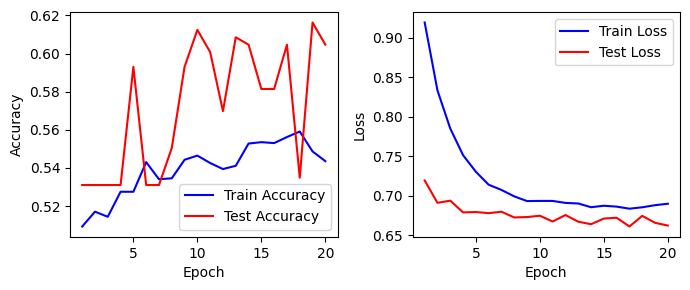

In [11]:
acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1,len(acc2)+1)
 
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
 
axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
 
axes[1].plot(epochs, loss2,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
 
# Adjusting layout for better spacing
plt.tight_layout()
 
# Display the figure
plt.show()

In [12]:
loss, accuracy = model.evaluate(x_test,y_test)
print(f'Test Accuracy {accuracy*100:.2f}%')

9/9 [==============================] - 5s 566ms/step - loss: 0.6623 - accuracy: 0.6047
Test Accuracy 60.47%


In [13]:
import numpy as np
from sklearn.metrics import classification_report

predict_x = model.predict(x_test)
predict1 = np.argmax(predict_x, axis = 1)
print(predict1)

target_names = ["Class {}".format(i) for i in range(2)]
print(classification_report(np.array([int(class_) for class_ in Y_test]), predict1, target_names = target_names))

9/9 [==============================] - 7s 535ms/step
[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0]
              precision    recall  f1-score   support

     Class 0       0.59      0.85      0.69       137
     Class 1       0.66      0.33      0.44       121

    accuracy                           0.60       258
   macro avg       0.62      0.59      0.57       258
weighted avg       0.62      0.60      0.57       258



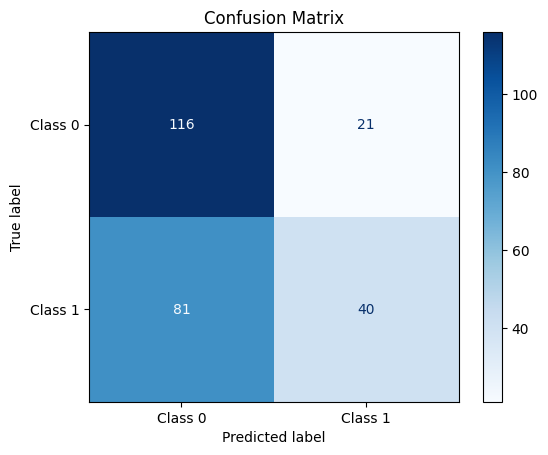

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Compute confusion matrix
cm = confusion_matrix(np.array([int(class_) for class_ in Y_test]), predict1)

#Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [15]:
model.save('EffNet_Final_Model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
import pickle

# Save the history object
with open('history_EffNet_Final.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay